In [1]:
import numpy as np                  
import pandas as pd                
import matplotlib.pyplot as plt    
import seaborn as sns
import mysql.connector
from mysql.connector import Error
import statsmodels.api as sm

In [2]:
def cargar_tablas_a_dataframes(host, database, user, password):
    """
    Se conecta a una base de datos MySQL y carga todas las tablas como DataFrames de Pandas
    con nombres dinámicos en el entorno global (ej. df_nombreTabla).
    """
    try:
        connection = mysql.connector.connect(
            host=host,
            database=database,
            user=user,
            password=password
        )

        if connection.is_connected():
            cursor = connection.cursor()  # Creación de un cursor para ejecutar consultas SQL
            cursor.execute("SHOW TABLES")  # Se ejecuta la consulta "SHOW TABLES" para listar las tablas

            tablas = [tabla[0] for tabla in cursor.fetchall()]  # Se obtienen los nombres de las tablas

            for tabla in tablas:
                cursor.execute(f"SELECT * FROM {tabla}")  # Se extraen los datos de cada tabla
                columnas = [columna[0] for columna in cursor.description]  # Nombres de columnas
                globals()[f'df_{tabla}'] = pd.DataFrame(cursor.fetchall(), columns=columnas)  # DataFrame dinámico
                print(f'df_{tabla}')  # Mostrar el nombre del DataFrame creado

    except Error as e:
        print("Error while connecting to MySQL:", e)  # Manejo de errores

    finally:
        if 'connection' in locals() and connection.is_connected():
            cursor.close()  # Cierra el cursor
            connection.close()  # Cierra la conexión
            print("MySQL connection is closed")  # Mensaje de cierre

In [3]:
cargar_tablas_a_dataframes('212.227.90.6', 'Equip_11', 'Equipo11', 'E1q2u3i4p5o11')

df_RRHH
df_RRHH_16062025
MySQL connection is closed


In [4]:
# Muestra todas las columnas
pd.set_option('display.max_columns', None)

# Opcional: muestra todo el ancho (evita recortes por pantalla estrecha)
pd.set_option('display.width', None)

# Opcional: ajusta el ancho máximo de cada columna si es muy largo
pd.set_option('display.max_colwidth', None)

### REGRESION LINEAL DEL MODELO COMPLETO

In [5]:
# 1. Cargar y limpiar datos
df = df_RRHH_16062025.copy()
df = df.dropna()

# 2. Convertir variables categóricas a dummies
df = pd.get_dummies(df, columns=['Reason_absence', 'Month_absence', 'Day_week', 'Seasons'], drop_first=True)

# 3. Separar variables
X = df.drop(columns=['ID', 'Absenteeism_hours'])
y = df['Absenteeism_hours']

# 4. Convertir booleanos a enteros
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)

# 6. Convertir todo a numérico
X = X.apply(pd.to_numeric, errors='raise')
y = pd.to_numeric(y, errors='raise')

# 7. Eliminar valores faltantes
X = X.dropna()
y = y.loc[X.index]

# 8. Ajustar modelo
X = sm.add_constant(X)
modelo = sm.OLS(y, X).fit()

# 9. Resultados
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:      Absenteeism_hours   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     5.091
Date:                Thu, 19 Jun 2025   Prob (F-statistic):           1.44e-27
Time:                        19:10:49   Log-Likelihood:                -3250.5
No. Observations:                 840   AIC:                             6621.
Df Residuals:                     780   BIC:                             6905.
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

### VARIABLES MAS SIGNIFICATIVAS DEL MODELO COMPLETO

In [6]:
# Obtener resumen del modelo como DataFrame
summary_df = modelo.summary2().tables[1]

# Filtrar variables con p-valor < 0.05
significant_vars = summary_df[summary_df['P>|t|'] < 0.05]

# Ordenar por importancia del coeficiente (absoluto)
significant_vars = significant_vars.reindex(significant_vars['Coef.'].abs().sort_values(ascending=False).index)

# Mostrar solo columnas relevantes
print("Variables significativamente asociadas al absentismo:\n")
print(significant_vars[['Coef.', 'P>|t|']])

Variables significativamente asociadas al absentismo:

                          Coef.         P>|t|
Reason_absence_9      32.269722  4.186398e-07
Reason_absence_12     13.491004  2.148813e-03
Reason_absence_6      10.826784  1.932553e-02
Reason_absence_19      9.275892  4.100428e-04
Disciplinary_failure  -8.486102  1.740042e-03
Reason_absence_13      8.106947  9.107804e-04
Reason_absence_11      6.535647  2.964230e-02
Reason_absence_28     -5.841190  9.027225e-03
Reason_absence_23     -4.658003  2.882455e-02
Day_week_5            -3.951990  5.524192e-03
Day_week_6            -3.532257  1.140627e-02
Day_week_4            -2.679716  4.300217e-02
Education             -1.900154  1.950665e-02
Son                    1.137252  1.738864e-02


### GRAFICO VARIABLES MAS SIGNIFICATIVAS DEL MODELO COMPLETO

C:\Users\santy\AppData\Local\Temp\ipykernel_27920\2170201405.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


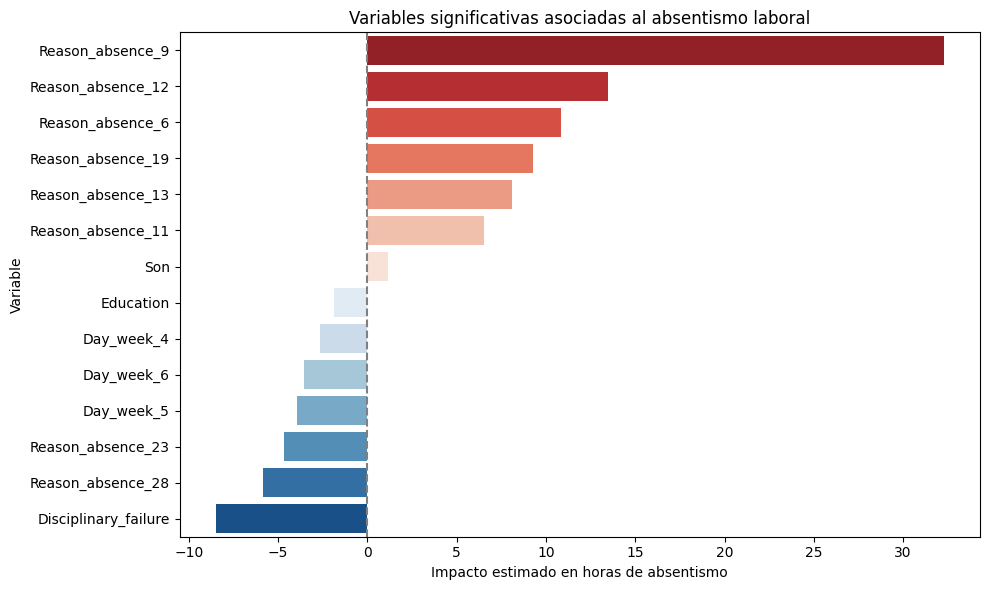

In [7]:
# 1. Extraer coeficientes significativos
summary_df = modelo.summary2().tables[1]
significant_vars = summary_df[summary_df['P>|t|'] < 0.05]['Coef.']

# 2. Separar positivos y negativos
positive_vars = significant_vars[significant_vars > 0].sort_values(ascending=False)
negative_vars = significant_vars[significant_vars < 0].sort_values(ascending=False)  # -1, -2, ..., -10

# 3. Crear degradados con la intensidad deseada
# NOTA: Invertimos los degradados aquí
red_colors = sns.color_palette("Reds", len(positive_vars))[::-1]  # rojo oscuro para valor mayor
blue_colors = sns.color_palette("Blues", len(negative_vars))      # azul claro para valor menos negativo

# 4. Combinar datos y colores
ordered_vars = pd.concat([positive_vars, negative_vars])
ordered_colors = red_colors + blue_colors  # respetamos el orden: positivos arriba, negativos abajo

# 5. Crear gráfico
plt.figure(figsize=(10, 6))
sns.barplot(
    y=ordered_vars.index,
    x=ordered_vars.values,
    palette=ordered_colors,
    orient='h'
)

plt.axvline(0, color='gray', linestyle='--')
plt.title('Variables significativas asociadas al absentismo laboral')
plt.xlabel('Impacto estimado en horas de absentismo')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

### REGRESION LINEAL DEL MODELO SIN LAS VARIABLES NO SIGNIFICATIVAS

In [8]:
# 1. Cargar y limpiar datos
df = df_RRHH_16062025.copy()
df = df.dropna()

# 2. Convertir variables categóricas a dummies
df = pd.get_dummies(df, columns=['Reason_absence', 'Month_absence', 'Day_week', 'Seasons'], drop_first=True)

# 3. Separar variables predictoras y variable objetivo
X = df.drop(columns=['ID', 'Absenteeism_hours'])
y = df['Absenteeism_hours']

# 4. Convertir booleanos a enteros
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)

# 5. Asegurar que todo sea numérico
X = X.apply(pd.to_numeric, errors='raise')
y = pd.to_numeric(y, errors='raise')

# 6. Eliminar valores faltantes
X = X.dropna()
y = y.loc[X.index]

# 7. Añadir constante
X = sm.add_constant(X)

# 8. Eliminar variables no significativas o con coeficiente pequeño
variables = list(X.columns)
modelo = sm.OLS(y, X[variables]).fit()

# Repetir hasta quedarnos con solo variables significativas y de impacto relevante
while True:
    summary = modelo.summary2().tables[1]
    # Excluir la constante
    summary = summary.drop(index='const', errors='ignore')
    
    # Identificar variables no significativas o con coeficiente entre -1 y 1
    drop_vars = summary[
        (summary['P>|t|'] > 0.05) | 
        ((summary['Coef.'] > -1) & (summary['Coef.'] < 1))
    ].index.tolist()
    
    if not drop_vars:
        break
    
    # Eliminar la variable menos significativa o con menor impacto
    variables = [var for var in variables if var not in drop_vars]
    modelo = sm.OLS(y, X[variables]).fit()

# 9. Mostrar resultados finales
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:      Absenteeism_hours   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     17.64
Date:                Thu, 19 Jun 2025   Prob (F-statistic):           4.63e-34
Time:                        19:10:49   Log-Likelihood:                -3291.7
No. Observations:                 840   AIC:                             6609.
Df Residuals:                     827   BIC:                             6671.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.0336 

### GRAFICA DEL MODELO SIN LAS VARIABLES NO SIGNIFICATIVAS

C:\Users\santy\AppData\Local\Temp\ipykernel_27920\276805583.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


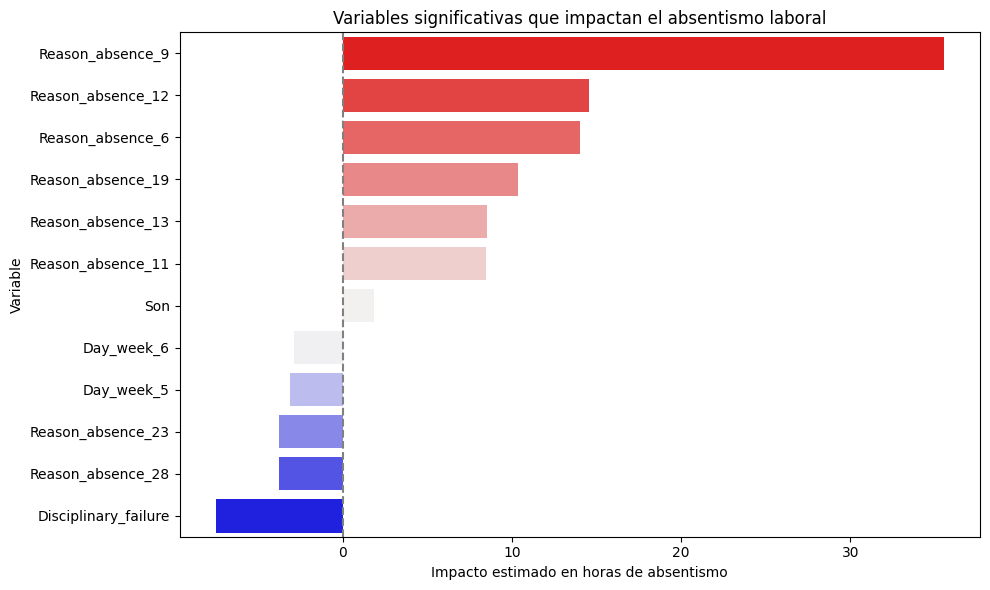

In [15]:
# 1. Extraer resumen del modelo
summary_df = modelo.summary2().tables[1].copy()

# 2. Quitar constante
summary_df = summary_df.drop(index='const', errors='ignore')

# 3. Filtrar variables significativas y con coeficiente relevante
summary_df = summary_df[(summary_df['P>|t|'] < 0.05) &
                        ((summary_df['Coef.'] > 1) | (summary_df['Coef.'] < -1))].copy()

# 4. Dividir y ordenar
positive_vars = summary_df[summary_df['Coef.'] > 0].sort_values(by='Coef.', ascending=False)
negative_vars = summary_df[summary_df['Coef.'] < 0].sort_values(by='Coef.', ascending=False)  # menos negativo a más negativo

# 5. Concatenar
ordered_df = pd.concat([positive_vars, negative_vars])

# 6. Crear colores degradados
reds = sns.light_palette("red", len(positive_vars), reverse=True).as_hex()
blues = sns.light_palette("blue", len(negative_vars)).as_hex()
colors = reds + blues

# 7. Graficar sin cambiar nombres
plt.figure(figsize=(10, 6))
sns.barplot(
    x=ordered_df['Coef.'],
    y=ordered_df.index,
    palette=colors
)
plt.axvline(0, color='gray', linestyle='--')
plt.title('Variables significativas que impactan el absentismo laboral')
plt.xlabel('Impacto estimado en horas de absentismo')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

### MISMO GRAFICO PERO CON LAS ETIQUETAS DEFINIDAS

C:\Users\santy\AppData\Local\Temp\ipykernel_27920\2327974159.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


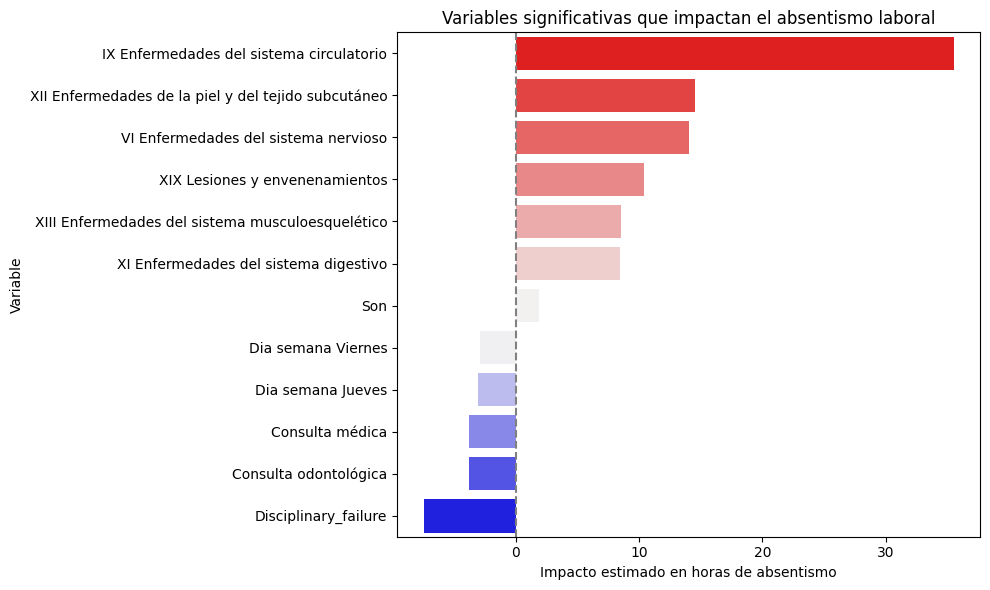

In [14]:
# Diccionario de mapeo para Reason_absence
reason_mapping = {
    'Reason_absence_6': 'VI Enfermedades del sistema nervioso',
    'Reason_absence_9': 'IX Enfermedades del sistema circulatorio',
    'Reason_absence_11': 'XI Enfermedades del sistema digestivo',
    'Reason_absence_12': 'XII Enfermedades de la piel y del tejido subcutáneo',
    'Reason_absence_13': 'XIII Enfermedades del sistema musculoesquelético',
    'Reason_absence_19': 'XIX Lesiones y envenenamientos',
    'Reason_absence_23': 'Consulta médica',
    'Reason_absence_28': 'Consulta odontológica',
    'Day_week_5': 'Dia semana Jueves',
    'Day_week_6': 'Dia semana Viernes'
}

# 1. Extraer resumen del modelo
summary_df = modelo.summary2().tables[1].copy()

# 2. Quitar constante
summary_df = summary_df.drop(index='const', errors='ignore')

# 3. Filtrar variables significativas y con coeficiente relevante
summary_df = summary_df[(summary_df['P>|t|'] < 0.05) &
                        ((summary_df['Coef.'] > 1) | (summary_df['Coef.'] < -1))].copy()

# 4. Dividir y ordenar
positive_vars = summary_df[summary_df['Coef.'] > 0].sort_values(by='Coef.', ascending=False)
negative_vars = summary_df[summary_df['Coef.'] < 0].sort_values(by='Coef.', ascending=False)  # <- CORREGIDO aquí

# 5. Concatenar
ordered_df = pd.concat([positive_vars, negative_vars])

# 6. Crear colores degradados
reds = sns.light_palette("red", len(positive_vars), reverse=True).as_hex()
blues = sns.light_palette("blue", len(negative_vars)).as_hex()  # <- va de menos negativo a más negativo
colors = reds + blues

# 7. Renombrar variables
labels = []
for var in ordered_df.index:
    labels.append(reason_mapping.get(var, var))  # renombra si existe, si no deja igual

# 8. Graficar
plt.figure(figsize=(10, 6))
sns.barplot(
    x=ordered_df['Coef.'],
    y=labels,
    palette=colors
)
plt.axvline(0, color='gray', linestyle='--')
plt.title('Variables significativas que impactan el absentismo laboral')
plt.xlabel('Impacto estimado en horas de absentismo')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()